In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


# CS 512 F24: Assignment 4
Due by 11/2/2024

**Name:** Tamilarasee Sethuraj

**Student ID:** A20553416




# 1. Semantic Segmentation



1. Dataset: Use the oxford_iiit_pet dataset from Keras or PyTorch.
- The dataset provides pixel-wise annotations for pets, including two classes: foreground (pet) and background, as well as an additional label for object contours. In this assignment, you will ignore the contour labels and focus only on the foreground segmentation.
- The dataset also includes breed-level labels. To simplify, you will convert the pet breed labels into binary cat/dog labels. Assign all cat breeds to the "cat" category and all dog breeds to the "dog"' category.--->This part was not needed as the species itself gives the binary class

2. Starter Code for Dataset Loading: Split the dataset into training and testing subsets, then split the training st into a training and validation subsets



In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the Oxford Pet Dataset
dataset, info = tfds.load("oxford_iiit_pet", with_info=True, as_supervised=False)

# Split into training and testing datasets
train_dataset = dataset['train']
test_dataset = dataset['test']

# Print some basic information about the dataset
print(info)

# sample: Access an image and label
for sample in train_dataset.take(1):
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    segmentation_mask = sample['segmentation_mask']
    label = sample['label']
    species = sample['species']

    print(f"Image shape: {image.shape}")
    print(f"Segmentation mask shape: {segmentation_mask.shape}")
    print(f"Species: {species}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.68ORIC_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.68ORIC_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp6hinzwzntfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel

In [3]:
# Merging contours with background
def binary_segmentation_mask(sample):
    image = sample['image']
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0

    mask = sample['segmentation_mask']
    mask = tf.image.resize(mask, (224, 224), method='nearest')
    binary_mask = tf.where(mask == 1, 1, 0)
    binary_mask = tf.cast(binary_mask, tf.int32)

    species = sample['species']

    return image, binary_mask, species

# Apply preprocessing to both train and test datasets
train_dataset = dataset['train'].map(binary_segmentation_mask)
test_dataset = dataset['test'].map(binary_segmentation_mask)

In [4]:
# split train to train and validation

total = info.splits['train'].num_examples

num_val_samples = int(total * 0.2)
num_train_samples = total - num_val_samples

print(f"Total samples: {total}")
print(f"Training samples: {num_train_samples}")
print(f"Validation samples: {num_val_samples}")

train_dataset = train_dataset.shuffle(total)
val_dataset = train_dataset.skip(num_train_samples)
train_dataset = train_dataset.take(num_train_samples)

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Total samples: 3680
Training samples: 2944
Validation samples: 736


3. Training a Simple CNN for Semantic Segmentation (without skip connections):
-  Train a simple convolutional neural network for supervised semantic segmentation (without skip connections).




In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def create_fcn_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling)
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    # Decoder (Upsampling)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

- Plot the training and validation loss and evaluation metric as a function of epochs.

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU

class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

model = create_fcn_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', CustomMeanIoU(num_classes=2, name='mean_iou')])
# we only use the image and mask as the main task here is segmentation only
train_fcn_seg = train_dataset.map(lambda x, y, z: (x, y))
val_fcn_seg = val_dataset.map(lambda x, y, z: (x, y))
# Train the model
history = model.fit(train_fcn_seg,
                    validation_data=val_fcn_seg,
                    epochs=50,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('fcn_model.keras', save_best_only=True)])

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.6785 - loss: 0.6056 - mean_iou: 0.2805 - val_accuracy: 0.6980 - val_loss: 0.5061 - val_mean_iou: 0.3010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7231 - loss: 0.4875 - mean_iou: 0.3601 - val_accuracy: 0.7470 - val_loss: 0.4911 - val_mean_iou: 0.4287
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7604 - loss: 0.4641 - mean_iou: 0.4493 - val_accuracy: 0.7958 - val_loss: 0.4257 - val_mean_iou: 0.5784
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7960 - loss: 0.4274 - mean_iou: 0.4919 - val_accuracy: 0.8261 - val_loss: 0.3783 - val_mean_iou: 0.6262
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8022 - loss: 0.4154 - mean_iou: 0.5041 - val_accuracy: 0.8080 - val_loss: 0.4012 - val_mean_iou: 0.6325
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8184 - loss: 0.3913 - mean_iou: 0.5275 - val_accuracy: 0.8049 - val_loss: 0.4137 - 


- Visualize some inference results.


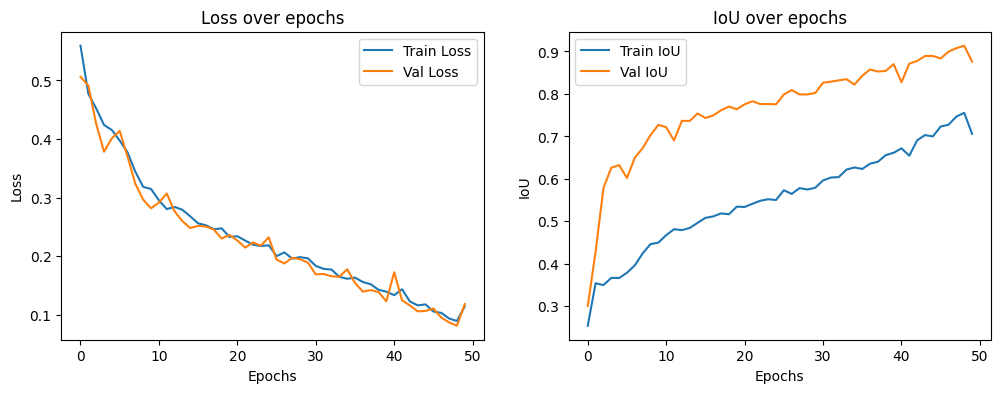

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['mean_iou'], label='Train IoU')
plt.plot(history.history['val_mean_iou'], label='Val IoU')
plt.title('IoU over epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [8]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])


- Provide quantitative training, validation, and testing results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


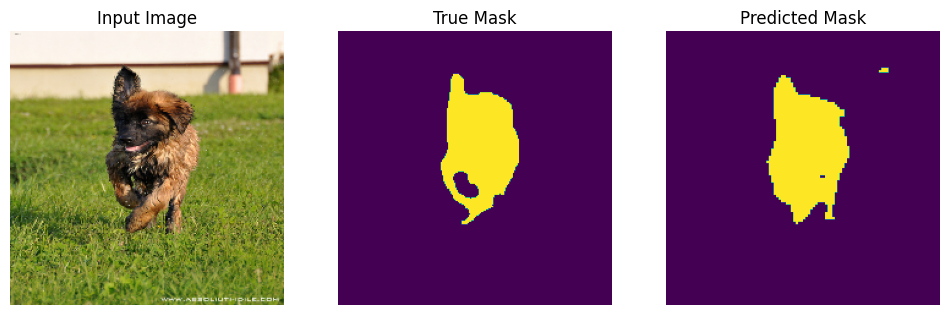

In [9]:
def visualize_prediction(model, dataset):
    for image, mask, species in dataset.take(1):
        prediction = model.predict(image)
        prediction = tf.argmax(prediction, axis=-1)

        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(image[0])
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(mask[0, ..., 0])
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(prediction[0])
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

visualize_prediction(model, test_dataset)

In [10]:
test_fcn_seg = test_dataset.map(lambda x, y, z: (x, y))
val_fcn_seg = val_dataset.map(lambda x, y, z: (x, y))

# Evaluate on test set
test_results = model.evaluate(test_fcn_seg)
# Evaluate on validation set
val_results = model.evaluate(val_fcn_seg)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test IoU: {test_results[2]:.4f}")

print(f"Validation Loss: {val_results[0]:.4f}")
print(f"Validation Accuracy: {val_results[1]:.4f}")
print(f"Validation IoU: {val_results[2]:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9030 - loss: 0.2695 - mean_iou: 0.6513
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9500 - loss: 0.1197 - mean_iou: 0.8856
Test Loss: 0.2749
Test Accuracy: 0.9021
Test IoU: 0.4820
Validation Loss: 0.1186
Validation Accuracy: 0.9506
Validation IoU: 0.8750



 4. Training a CNN for Semantic Segmentation with Skip Connections (U-Net):
 -  Train a CNN for semantic segmentation with skip connections (as in U-Net)
 - Evaluate and visualize the results as before.

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose

def unet_model(input_size=(224,224,3), num_classes=2):
    inputs = Input(input_size)

    # Encoder (Downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (Upsampling)
    up5 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the U-Net model
unet = unet_model()
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 224, 224, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 224, 224, 64)   │         36,928 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 64)   │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 128)    │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 56, 56, 256)    │        590,080 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 256)    │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 56, 56, 256)    │        524,544 │ conv2d_17[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 56, 56, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 56, 56, 256)    │        590,080 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1   

 Total params: 7,697,410 (29.36 MB)

 Trainable params: 7,697,410 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

unet.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', CustomMeanIoU(num_classes=2, name='mean_iou')])

# Prepare the datasets
train_unet = train_dataset.map(lambda x, y, z: (x, y))
val_unet = val_dataset.map(lambda x, y, z: (x, y))

# Train the model
history_unet = unet.fit(train_unet,
                        validation_data=val_unet,
                        epochs=50,
                        callbacks=[tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True)])

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.6782 - loss: 0.6606 - mean_iou: 0.2776 - val_accuracy: 0.7001 - val_loss: 0.5611 - val_mean_iou: 0.3012
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.6987 - loss: 0.5567 - mean_iou: 0.2976 - val_accuracy: 0.7793 - val_loss: 0.4500 - val_mean_iou: 0.5792
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.7773 - loss: 0.4563 - mean_iou: 0.4779 - val_accuracy: 0.7909 - val_loss: 0.4458 - val_mean_iou: 0.5715
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.7892 - loss: 0.4436 - mean_iou: 0.4895 - val_accuracy: 0.7893 - val_loss: 0.4426 - val_mean_iou: 0.5863
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.7972 - loss: 0.4299 - mean_iou: 0.4985 - val_accuracy: 0.8074 - val_loss: 0.4119 - val_mean_iou: 0.6107
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.8068 - loss: 0.4136 - mean_iou: 0.5134 - val_accuracy: 0.8146 - val_loss: 0.40

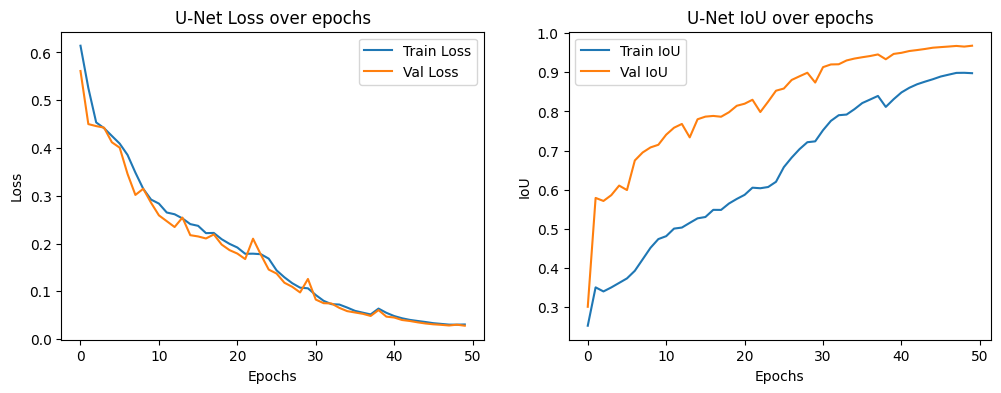

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history_unet.history['loss'], label='Train Loss')
plt.plot(history_unet.history['val_loss'], label='Val Loss')
plt.title('U-Net Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_unet.history['mean_iou'], label='Train IoU')
plt.plot(history_unet.history['val_mean_iou'], label='Val IoU')
plt.title('U-Net IoU over epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [14]:
# Prepare test dataset
test_unet = test_dataset.map(lambda x, y, z: (x, y))

# Evaluate on test set
test_results_unet = unet.evaluate(test_unet)
print(f"Test Loss: {test_results_unet[0]:.4f}")
print(f"Test Accuracy: {test_results_unet[1]:.4f}")
print(f"Test IoU: {test_results_unet[2]:.4f}")

# Evaluate on validation set
val_results_unet = unet.evaluate(val_unet)
print(f"Validation Loss: {val_results_unet[0]:.4f}")
print(f"Validation Accuracy: {val_results_unet[1]:.4f}")
print(f"Validation IoU: {val_results_unet[2]:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9056 - loss: 0.5236 - mean_iou: 0.6567
Test Loss: 0.5327
Test Accuracy: 0.9050
Test IoU: 0.4897
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9881 - loss: 0.0283 - mean_iou: 0.9714
Validation Loss: 0.0282
Validation Accuracy: 0.9881
Validation IoU: 0.9684


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


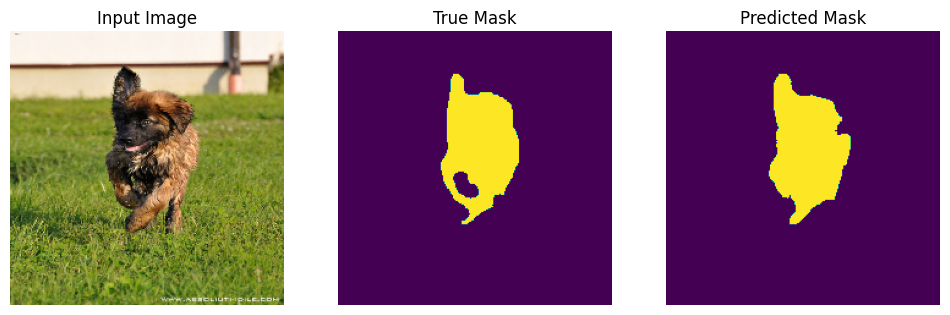

In [15]:
def visualize_prediction_unet(model, dataset):
    for image, mask in dataset.take(1):
        prediction = model.predict(image)
        prediction = tf.argmax(prediction, axis=-1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1,3,1)
        plt.imshow(image[0])
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask[0, ..., 0])
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(prediction[0])
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

visualize_prediction_unet(unet, test_unet)

From results, we see that Unet performs better due to the skip connections that helps in recreating the image for image segmentation more clearly